In [174]:
# IMPORTING REQUIRED LIBRARIES

import torch
import numpy as np
import scipy as sp
from numpy import ndarray 
from typing import Any, Callable, Dict, List, Optional, Tuple, Union, cast
import math
import matplotlib as plt
import scipy.constants

In [3]:
#BASIC OPERATORS

def annihilation(dimension: int) -> ndarray:
    """
    Returns a dense matrix of size dimension x dimension representing the annihilation
    operator in number basis.
    """
    offdiag_elements = np.sqrt(range(1, dimension))
    return np.diagflat(offdiag_elements, 1)

def creation(dimension: int) -> ndarray:
    """
    Returns a dense matrix of size dimension x dimension representing the creation
    operator in number basis.
    """
    return annihilation(dimension).T




In [203]:
#SOME GLOBAL PARAMETERS
R_k = sp.constants.h / (sp.constants.e**2.0)
R_0 = 50
T = 0.015
M = 400
Delta = 3.4e-4
x_qp = 3e-6

omega_low = 1e-9 * 2 * np.pi
omega_high = 3 * 2 * np.pi
t_exp = 1e4
A_flux = 1e-6
A_cc = 1e-7

#T1 RELATED FUNCTIONS

#T1 CAPACITIVE FUNCTIONS

def q_cap_fun(omega) -> torch.Tensor:
    return (
        1e6
        * torch.pow((2 * np.pi * 6e9 / torch.abs(omega)) , 0.7)
    )

def calc_therm_ratio(
    omega: torch.Tensor, T: float
) -> torch.Tensor:
    return (sp.constants.hbar * omega) / (sp.constants.k * T)

def spectral_density_cap(omega,EJ,EC,EL,flux):
    
    therm_ratio = calc_therm_ratio(omega, T)
    s = (
        2
        * 8
        * EC
        / q_cap_fun(omega)
        * (1 / torch.tanh(0.5 * torch.abs(therm_ratio)))
        / (1 + torch.exp(-therm_ratio))
    )
    s *= (
        2 * np.pi
    )  # We assume that system energies are given in units of frequency
    return s



In [35]:
#T1 CHARGE IMPEDANCE FUNCTIONS

def spectral_density_ci(omega,EJ,EC,EL,flux):
    # Note, our definition of Q_c is different from Zhang et al (2020) by a
    # factor of 2

    Q_c = R_k / (8 * np.pi * complex(R_0).real)
    therm_ratio = calc_therm_ratio(omega, T)
    s = (
        2
        * ( omega / 1e9 ) #annoying unit stuff - gotta convert back to GHz
        / Q_c
        * (1 / torch.tanh(0.5 * therm_ratio))
        / (1 + torch.exp(-therm_ratio))
    )
    return s

# T1 FLUX BIAS LINE FUNCTIONS

def spectral_density_fbl(omega,EJ,EC,EL,flux):
    """
    Our definitions assume that the noise_op is dH/dflux.
    """

    therm_ratio = calc_therm_ratio(omega, T)

    s = (
        2
        * (2 * np.pi) ** 2
        * M**2
        * ( omega / 1e9 ) #annoying unit stuff - gotta convert back to GHz
        * sp.constants.hbar
        / complex(R_0).real
        * (1 / torch.tanh(0.5 * therm_ratio))
        / (1 + torch.exp(-therm_ratio))
    )
    # We assume that system energies are given in units of frequency and that
    # the noise operator to be used with this `spectral_density` is dH/dflux.
    # Hence we have to convert  2 powers of frequency to standard units
    s *= 1e9 ** 2.0
    return s



In [36]:
#T1 INDUCTIVE FUNCTIONS

def q_ind_fun(omega):

    therm_ratio = abs(calc_therm_ratio(omega, T))
    therm_ratio_500MHz = calc_therm_ratio(
        torch.tensor(2 * np.pi * 500e6), T
    )
    
    return (
        500e6
        * (
            torch.special.scaled_modified_bessel_k0(1 / 2 * therm_ratio_500MHz)
            * torch.sinh(1 / 2 * therm_ratio_500MHz)
            / torch.exp(1 / 2 * therm_ratio_500MHz)
        )
        / (
            torch.special.scaled_modified_bessel_k0(1 / 2 * therm_ratio)
            * torch.sinh(1 / 2 * therm_ratio)
            / torch.exp(1 / 2 * therm_ratio)
        )
    )

def spectral_density_ind(omega,EJ,EC,EL,flux):

    therm_ratio = calc_therm_ratio(omega,T)
    s = (
        2
        * EL
        / q_ind_fun(omega)
        * (1 / torch.tanh(0.5 * torch.abs(therm_ratio)))
        / (1 + torch.exp(-therm_ratio))
    )
    s *= (
        2 * np.pi
    )  # We assume that system energies are given in units of frequency
    return s

In [99]:
# T1 QUASIPARTICLE TUNNELLING FUNCTIONS

def y_qp_fun(omega,EJ,EC,EL,flux):
    
    omega = torch.abs(omega)
    Delta_in_Hz = Delta * sp.constants.e / sp.constants.h

    omega_in_Hz = omega / (2 * np.pi) 
    EJ_in_Hz = EJ * 1e9 # GHz to Hz

    therm_ratio = calc_therm_ratio(omega, T)
    Delta_over_T = calc_therm_ratio(
        2 * np.pi * Delta_in_Hz, T
    )

    re_y_qp = (
        np.sqrt(2 / np.pi)
        * (8 / R_k)
        * (EJ_in_Hz / Delta_in_Hz)
        * (2 * Delta_in_Hz / omega_in_Hz) ** (3 / 2)
        * x_qp
        * torch.sqrt(1 / 2 * therm_ratio)
        * torch.special.scaled_modified_bessel_k0(1 / 2 * torch.abs(therm_ratio))
        * torch.sinh(1 / 2 * therm_ratio)
        / torch.exp(1 / 2 * torch.abs(therm_ratio))
    )

    return re_y_qp

def spectral_density_qt(omega,EJ,EC,EL,flux):
    """Based on Eq. 19 in Smith et al (2020)."""
    therm_ratio = calc_therm_ratio(omega, T)

    return (
        2
        * omega / 1e9
        * complex(y_qp_fun(omega,EJ,EC,EL,flux)).real
        * (1 / torch.tanh(0.5 * therm_ratio))
        / (1 + torch.exp(-therm_ratio))
    )

In [113]:
#GENERAL T1 FUNCTION

def t1(
        noise_op: torch.Tensor,
        spectral_density: Callable,
        eigvals: torch.Tensor,
        eigvecs: torch.Tensor,
        EJ: torch.Tensor,
        EC: torch.Tensor,
        EL: torch.Tensor,
        flux: torch.Tensor,
    ):

        # We assume that the energies in `evals` are given in the units of frequency
        # and *not* angular frequency. The function `spectral_density` is assumed to
        # take as a parameter an angular frequency, hence we have to convert.


        ground = eigvecs[:,0]
        excited = eigvecs[:,1]
        ground_E = eigvals[0]
        excited_E = eigvals[1]

        omega = 2 * np.pi * (excited_E - ground_E) * 1e9

        s = (
            spectral_density(omega,EJ,EC,EL,flux) + spectral_density(-omega,EJ,EC,EL,flux)
        )
        
        rate = torch.matmul(noise_op,ground.unsqueeze(0).T)
        rate = torch.matmul(excited.unsqueeze(0).conj(),rate)
        rate = torch.pow(torch.abs(rate) , 2) * s

        return rate

In [98]:
# GENERAL TPHI FUNCTION

def tphi_1_over_f(
        A_noise: float,
        noise_op: torch.Tensor,
        eigvals: torch.Tensor,
        eigvecs: torch.Tensor,
        i: int = 1,
        j: int = 0
    ) -> float:

        ground = eigvecs[:,j]
        excited = eigvecs[:,i]
        ground_E = eigvals[j]
        excited_E = eigvals[i]

        rate = torch.abs(
            torch.matmul(ground.unsqueeze(0).conj(),torch.matmul(noise_op,ground.unsqueeze(0).T))
            - torch.matmul(excited.unsqueeze(0).conj(),torch.matmul(noise_op,excited.unsqueeze(0).T))
        )
        
        rate *= A_noise * np.sqrt(2 * np.abs(np.log(omega_low * t_exp)))

        # We assume that the system energies are given in units of frequency and
        # not the angular frequency, hence we have to multiply by `2\pi`
        rate *= 2 * np.pi

        return rate

In [206]:
# CALCULATES T1 FOR FLUXONIUM
def t1_effective (
    EJ: torch.Tensor,
    EC: torch.Tensor,
    EL: torch.Tensor,
    flux: torch.Tensor,
    dim: float,
):
    
    # PART 1 - GET HAMILTONIAN
    plasma_energy = torch.sqrt(8.0*EL*EC)
    diag_elements = [(i + 0.5) for i in range(dim)]
    lc_osc = torch.tensor(np.diag(diag_elements),dtype=torch.double)
    lc_osc = lc_osc * plasma_energy

    phi_osc = torch.pow((8.0 * EC / EL) , 0.25)
    phi = (
            (torch.tensor(creation(dim),dtype=torch.double) + torch.tensor(annihilation(dim),dtype=torch.double))
            * phi_osc/ math.sqrt(2)
        )

    argument = phi + 2 * np.pi * flux * torch.tensor(np.eye(dim),dtype=torch.double)

    cos_phi = (torch.linalg.matrix_exp(argument*1j)+torch.linalg.matrix_exp(argument*-1j))/2
    sin_phi = (torch.linalg.matrix_exp(argument*1j)-torch.linalg.matrix_exp(argument*-1j))/2j

    n_op = (
                1j
                * (torch.tensor(creation(dim),dtype=torch.double) - torch.tensor(annihilation(dim),dtype=torch.double))
                / (phi_osc * math.sqrt(2))
            )

    d_ham_d_flux = -2 * np.pi * EJ * sin_phi

    H = lc_osc - EJ*cos_phi

    # PART 2 - Get eigenvalues

    eigvals,eigvecs = torch.linalg.eigh(H)

    # PART 3 - Find rate

    t1_rate = torch.zeros([1,1],dtype=torch.double)

    #3.1 t1_capacitive

    t1_rate += t1(n_op, spectral_density_cap, eigvals, eigvecs, EJ, EC, EL, flux)

    #3.2 t1_charge_impedance - not included for fluxonium

    #t1_rate += t1(n_op, spectral_density_ci, eigvals, eigvecs, EJ, EC, EL, flux)

    #3.3 t1_flux_bias_line

    t1_rate += t1(d_ham_d_flux, spectral_density_fbl, eigvals, eigvecs, EJ, EC, EL, flux)

    #3.4 t1_inductive

    t1_rate += t1(phi+0j, spectral_density_ind, eigvals, eigvecs, EJ, EC, EL, flux)

    #3.5 t1_quasiparticle_tunneling - a little dubious

    qt_argument = argument/2
    qt_noise = (torch.linalg.matrix_exp(qt_argument*1j)-torch.linalg.matrix_exp(qt_argument*-1j))/2j

    t1_rate += t1(qt_noise+0j, spectral_density_qt, eigvals, eigvecs, EJ, EC, EL, flux)

    # PART 4 - Get time

    T1 = 1/t1_rate

    return T1

In [207]:
# T2 FOR FLUXONIUM
def t2_effective (
    EJ: torch.Tensor,
    EC: torch.Tensor,
    EL: torch.Tensor,
    flux: torch.Tensor,
    dim: float,
):
    
    # PART 1 - GET HAMILTONIAN
    plasma_energy = torch.sqrt(8.0*EL*EC)
    diag_elements = [(i + 0.5) for i in range(dim)]
    lc_osc = torch.tensor(np.diag(diag_elements),dtype=torch.double)
    lc_osc = lc_osc * plasma_energy

    phi_osc = torch.pow((8.0 * EC / EL) , 0.25)
    phi = (
            (torch.tensor(creation(dim),dtype=torch.double) + torch.tensor(annihilation(dim),dtype=torch.double))
            * phi_osc/ math.sqrt(2)
        )

    argument = phi + 2 * np.pi * flux * torch.tensor(np.eye(dim),dtype=torch.double)

    cos_phi = (torch.linalg.matrix_exp(argument*1j)+torch.linalg.matrix_exp(argument*-1j))/2
    sin_phi = (torch.linalg.matrix_exp(argument*1j)-torch.linalg.matrix_exp(argument*-1j))/2j

    n_op = (
                1j
                * (torch.tensor(creation(dim),dtype=torch.double) - torch.tensor(annihilation(dim),dtype=torch.double))
                / (phi_osc * math.sqrt(2))
            )

    d_ham_d_flux = -2 * np.pi * EJ * sin_phi
    d_ham_d_EJ = - cos_phi


    H = lc_osc - EJ*cos_phi

    # PART 2 - Get eigenvalues

    eigvals,eigvecs = torch.linalg.eigh(H)

    # PART 3 - Find rate from T1

    t2_rate = torch.zeros([1,1],dtype=torch.double)

    #3.1 t1_capacitive

    t2_rate += 0.5 * t1(n_op, spectral_density_cap, eigvals, eigvecs, EJ, EC, EL, flux)

    #3.2 t1_charge_impedance - not included for fluxonium

    #t2_rate += 0.5 * t1(n_op, spectral_density_ci, eigvals, eigvecs, EJ, EC, EL, flux)

    #3.3 t1_flux_bias_line

    t2_rate += 0.5 * t1(d_ham_d_flux, spectral_density_fbl, eigvals, eigvecs, EJ, EC, EL, flux)

    #3.4 t1_inductive

    t2_rate += 0.5 * t1(phi+0j, spectral_density_ind, eigvals, eigvecs, EJ, EC, EL, flux)

    #3.5 t1_quasiparticle_tunneling

    qt_argument = argument/2
    qt_noise = (torch.linalg.matrix_exp(qt_argument*1j)-torch.linalg.matrix_exp(qt_argument*-1j))/2j

    t2_rate += 0.5 * t1(qt_noise+0j, spectral_density_qt, eigvals, eigvecs, EJ, EC, EL, flux)

    # PART 4 - Find rate from Tphi

    #4.1 tphi_1_over_f_flux

    t2_rate += tphi_1_over_f(A_flux, d_ham_d_flux, eigvals, eigvecs)
    
    #4.2 tphi_1_over_f_cc

    t2_rate += tphi_1_over_f(A_cc, d_ham_d_EJ, eigvals, eigvecs)

    # PART 5 - Get time

    T2 = 1/t2_rate

    return T2

In [208]:
# Tphi FOR FLUXONIUM
def tphi_effective (
    EJ: torch.Tensor,
    EC: torch.Tensor,
    EL: torch.Tensor,
    flux: torch.Tensor,
    dim: float,
):
    
    # PART 1 - GET HAMILTONIAN
    plasma_energy = math.sqrt(8.0*EL*EC)
    diag_elements = [(i + 0.5) for i in range(dim)]
    lc_osc = torch.tensor(np.diag(diag_elements),dtype=torch.double)
    lc_osc = lc_osc * plasma_energy

    phi_osc = torch.pow((8.0 * EC / EL) , 0.25)
    phi = (
            (torch.tensor(creation(dim),dtype=torch.double) + torch.tensor(annihilation(dim),dtype=torch.double))
            * phi_osc/ math.sqrt(2)
        )

    argument = phi + 2 * np.pi * flux * torch.tensor(np.eye(dim),dtype=torch.double)

    cos_phi = (torch.linalg.matrix_exp(argument*1j)+torch.linalg.matrix_exp(argument*-1j))/2
    sin_phi = (torch.linalg.matrix_exp(argument*1j)-torch.linalg.matrix_exp(argument*-1j))/2j

    n_op = (
                1j
                * (torch.tensor(creation(dim),dtype=torch.double) - torch.tensor(annihilation(dim),dtype=torch.double))
                / (phi_osc * math.sqrt(2))
            )

    d_ham_d_flux = -2 * np.pi * EJ * sin_phi
    d_ham_d_EJ = - cos_phi


    H = lc_osc - EJ*cos_phi

    # PART 2 - Get eigenvalues

    eigvals,eigvecs = torch.linalg.eigh(H)

    # PART 3 - Find rate from Tphi

    tphi_rate = torch.zeros([1,1],dtype=torch.double)

    #3.1 tphi_1_over_f_flux

    tphi_rate += tphi_1_over_f(A_flux, d_ham_d_flux, eigvals, eigvecs)
    
    #3.2 tphi_1_over_f_cc

    tphi_rate += tphi_1_over_f(A_cc, d_ham_d_EJ, eigvals, eigvecs)

    # PART 5 - Get time

    Tphi = 1/tphi_rate

    return Tphi

In [201]:
#TENSORS

# INPUT

#random values
EJ = torch.rand(1, requires_grad=True, dtype=torch.double)
EC = torch.rand(1, requires_grad=True, dtype=torch.double)
EL = torch.rand(1, requires_grad=True, dtype=torch.double)
flux = torch.tensor([0.5], requires_grad=True, dtype=torch.double)

EJ.data = EJ.data * (20 - 2.5) + 2.5
EC.data = EC.data * (8 - 1e-3) + 1e-3
EL.data = EL.data * (10 - 2e-1) + 2e-1

# PARAMETERS

dim = 110

learn_rate = 3e4

# BOUNDS

EJ_bounds = [2.5, 150]
EC_bounds = [1e-3, 8]
EL_bounds = [2e-1, 10]
flux_bounds = [0,1]

# RECORDING VALUES

EJ_vals = [EJ.item()]
EC_vals = [EC.item()]
EL_vals = [EL.item()]
cost_vals = []

# GRADIENT DESCENT

max_T2 = 0

for i in range(0,700):

    #reinstantiate values
    EJ = torch.tensor(EJ.item(), requires_grad=True, dtype=torch.double)
    EC = torch.tensor(EC.item(), requires_grad=True, dtype=torch.double)
    EL = torch.tensor(EL.item(), requires_grad=True, dtype=torch.double)
    flux = torch.tensor(flux.item(), requires_grad=True, dtype=torch.double)

    T2 = t2_effective(EJ,EC,EL,flux,dim)

    if T2 > max_T2:
        max_T2 = T2
    
    #autograd on objective function
    cost = 1/T2
    cost.backward()

    cost_vals.append(cost.item())

    print("CYCLE: ",i)
    print("T = ",T2.item(), ", cost = ", cost.item(), ", Best T = ", max_T2.item())
    print("EJ,EC,EL,flux = ",EJ.item(),EC.item(),EL.item(),flux.item())
    print("change EJ,EC,EL,flux = ",EJ.grad.item()*learn_rate,EC.grad.item()*learn_rate,EL.grad.item()*learn_rate,flux.grad.item()*learn_rate)
    
    #update parameters according to gradient
    with torch.no_grad():
        # Near the boundary, we project the gradient onto it. This is the typical approach to constraints.
        if EJ - EJ.grad*learn_rate > EJ_bounds[0] and EJ.data - EJ.grad*learn_rate < EJ_bounds[1]:
            EJ -= EJ.grad*learn_rate
        elif EJ - EJ.grad*learn_rate <= EJ_bounds[0]:
            EJ += (torch.tensor(EJ_bounds[0]) - EJ)
        else:
            EJ += (torch.tensor(EJ_bounds[1]) - EJ)
        EJ_vals.append(EJ.item())
        
        if EC - EC.grad*learn_rate > EC_bounds[0] and EC - EC.grad*learn_rate < EC_bounds[1]:
            EC -= EC.grad*learn_rate
        elif EC - EC.grad*learn_rate <= EC_bounds[0]:
            EC += (torch.tensor(EC_bounds[0]) - EC)
        else:
            EC += (torch.tensor(EC_bounds[1]) - EC)
        EC_vals.append(EC.item())
        
        if EL - EL.grad*learn_rate > EL_bounds[0] and EL - EL.grad*learn_rate < EL_bounds[1]:
            EL -= EL.grad*learn_rate
        elif EL - EL.grad*learn_rate <= EL_bounds[0]:
            EL += (torch.tensor(EL_bounds[0]) - EL)
        else:
            EL += (torch.tensor(EL_bounds[1]) - EL)
        EL_vals.append(EL.item())

    EJ.grad = None
    EC.grad = None
    EL.grad = None
    flux.grad = None

#append last cost value to cost array

T2 = t2_effective(EJ,EC,EL,flux,dim)

cost = 1/T2
print("CYCLE: END")
print("T = ",T2.item(), ", cost = ", cost.item(), ", Best T = ", max_T2.item())
print("EJ,EC,EL,flux = ",EJ.item(),EC.item(),EL.item(),flux.item())

cost_vals.append(cost.item())


CYCLE:  0
T =  920050.5891922889 , cost =  1.0868967551859279e-06 , Best T =  920050.5891922889
EJ,EC,EL,flux =  18.53721753802328 3.735943066671313 2.9251987675536832 0.5
change EJ,EC,EL,flux =  -0.004671585616807624 0.016636354147477772 0.019520482957073575 7727.111976834886
CYCLE:  1
T =  937453.3443428228 , cost =  1.0667197530785107e-06 , Best T =  937453.3443428228
EJ,EC,EL,flux =  18.54188912364009 3.7193067125238355 2.90567828459661 0.5
change EJ,EC,EL,flux =  -0.004508676838908665 0.016128219232424412 0.019027150544705818 -7814.504745643469
CYCLE:  2
T =  954445.8879970644 , cost =  1.0477283338697518e-06 , Best T =  954445.8879970644
EJ,EC,EL,flux =  18.546397800479 3.703178493291411 2.886651134051904 0.5
change EJ,EC,EL,flux =  -0.004354303900062121 0.01564407780223643 0.018560263655309907 -7900.530586551419
CYCLE:  3
T =  971033.5995652747 , cost =  1.0298304821251225e-06 , Best T =  971033.5995652747
EJ,EC,EL,flux =  18.55075210437906 3.6875344154891745 2.868090870396594 0

 C:\Users\dicid\AppData\Local\Temp\ipykernel_25632\1331673272.py: 8

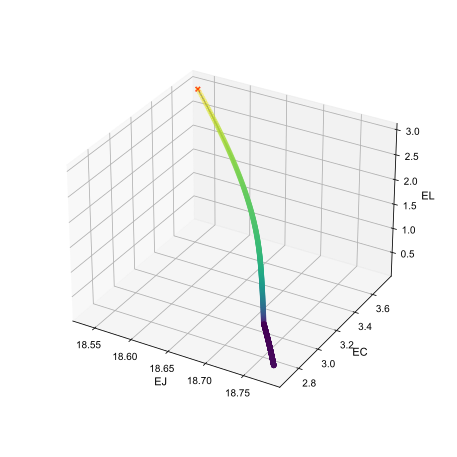

[18.725776527065428, 2.995468000539339, 0.20000000298023224, 6877.320191855789]


In [209]:
#PLOTTING THE PATH OF A GD RUN

import matplotlib as plt
import matplotlib.pyplot as plt

fig = plt.figure(figsize=[8,8])
ax = fig.add_subplot(projection='3d')
ax.dist = 12
ax.set_xlabel('EJ')
ax.set_ylabel('EC')
ax.set_zlabel('EL')

ax.plot(np.array(EJ_vals), np.array(EC_vals), np.array(EL_vals), 'gray', zorder=1)
ax.scatter(np.array(EJ_vals), np.array(EC_vals), np.array(EL_vals), c=np.array(np.log(cost_vals)), cmap='viridis', marker="o", zorder=2)

ax.scatter(np.array(EJ_vals)[0], np.array(EC_vals)[0], np.array(EL_vals)[0],marker='x',color='r', zorder=3)
plt.colorbar
plt.show()

#UNCOMMENT TO SAVE AS PNG
#fig.savefig('GD_path.png', bbox_inches='tight')

T_vals = 1/(np.array(cost_vals))
i = np.argmax(T_vals)
print([EJ_vals[i],EC_vals[i],EL_vals[i],T_vals[i]/1000])


In [69]:
import pickle
pickle.dump([EJ_vals,EC_vals,EL_vals,T1_vals],open("descent_path",'wb'))

 C:\Users\dicid\AppData\Local\Temp\ipykernel_13508\4147520719.py: 32

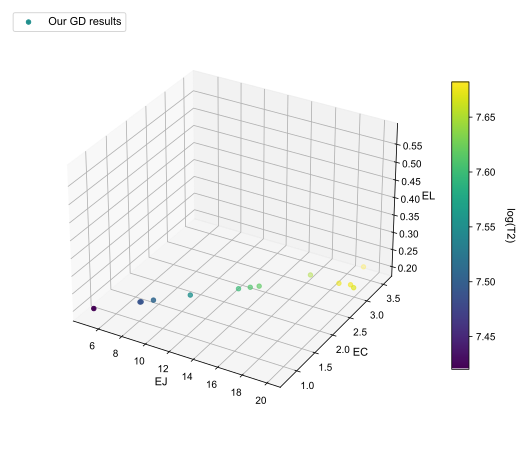

In [6]:
# PLOTTING MULTIPLE GD RESULTS

T2_data = np.array(
    [
        [10.048433912010987, 1.7094860967554957, 0.20000000298023224, 5954.87847895793],
        [7.362395737623504, 1.2142153737653134, 0.20000000298023224, 5554.210606485795],
        [19.21967354208937, 3.554073968271799, 0.20000000298023224, 6935.160006764835],
        [13.810527286464692, 2.3818358945103077, 0.20000000298023224, 6431.492990557696],
        [7.419082486918439, 1.2248977801961263, 0.20000000298023224, 5563.337883076131],
        [4.929063624496952, 0.7599680467812014, 0.20000000298023224, 5129.6570147732455],
        [13.317981261776893, 2.295085131867007, 0.20000000298023224, 6373.527939101629],
        [19.56649212445493, 3.0413145532263424, 0.20000000298023224, 6892.315240378897],
        [12.672061125867447, 2.180977005869106, 0.20000000298023224, 6295.6812962205195],
        [16.332457326208388, 2.994308048917942, 0.20000000298023224, 6669.289646519838],
        [19.958773928220637, 2.9936118756047407, 0.20000000298023224, 6823.4634225827285],
        [8.07618571084848, 1.346575655984413, 0.20000000298023224, 5666.795832898853],
        [18.725776527065428, 2.995468000539339, 0.20000000298023224, 6877.320191855789]
    ]
)
T2_lit = np.array(
    [
        [10,1,0.58,510]
        #[3.43, 1, 0.58, 510]
    ]
)

import matplotlib as plt
import matplotlib.pyplot as plt

fig = plt.figure(figsize=[8,8])
ax = fig.add_subplot(projection='3d')
ax.dist = 12
ax.set_xlabel('EJ')
ax.set_ylabel('EC')
ax.set_zlabel('EL')

EJ_vals = T2_data[:,0]
EC_vals = T2_data[:,1]
EL_vals = T2_data[:,2]
cost_vals = 1/(T2_data[:,3])

sp = ax.scatter(np.array(EJ_vals), np.array(EC_vals), np.array(EL_vals), c=np.array(np.log10(1/cost_vals**2)), cmap='viridis', marker="o",label='Our GD results')

#ax.scatter(T2_lit[:,0], T2_lit[:,1], T2_lit[:,2],marker='x',color='r',label='experimental choice')
ax.scatter(T2_lit[:,0], T2_lit[:,1], T2_lit[:,2],marker='x',color='r',alpha=0)
plt.legend(loc='upper left')
cbar = plt.colorbar(sp,orientation='vertical',cax = fig.add_axes([0.9, 0.25, 0.03, 0.5]))
cbar.set_label('log(T2)', rotation=270, labelpad=20)
plt.show()

fig.savefig('Results.png', bbox_inches='tight')



In [1]:
#PLOTTING DECOHERENCE TIMES WITH SCQUBITS

import scqubits as scq
import numpy as np
import matplotlib.pyplot as plt

#define the qubit
fluxonium = scq.Fluxonium(EJ = 1,
                               EC = 1,
                               EL = 1,
                               flux = 0.5,
                               cutoff = 110)


#set values of parameters to plot over
EC = np.linspace(0.1,5,20) #EC range
EJ = np.linspace(1,20,20) #EJ range
EL = np.linspace(0.2,5,5) #EL range

#make empty arrays to record values over
T2 = np.zeros([len(EC),len(EJ),len(EL)])
T1 = np.zeros([len(EC),len(EJ),len(EL)])
Tphi = np.zeros([len(EC),len(EJ),len(EL)])


#iterate over parameters and fill time arrays
for i in range(0,len(EC)):
    fluxonium.EC = EC[i]
    
    for j in range(0,len(EJ)):
        fluxonium.EJ = EJ[j]

        for k in range(0,len(EL)):
            fluxonium.EL = EL[k]
        
            T1[i,j,k] = fluxonium.t1_effective(noise_channels=None)/1000 #this is in nanoseconds, so 1000 converts to microseconds
            T2[i,j,k] = fluxonium.t2_effective(noise_channels=None)/1000
            Tphi[i,j,k] = fluxonium.t2_effective(noise_channels=["tphi_1_over_f_cc","tphi_1_over_f_flux"])/1000



See documentation for details.
This warning can be disabled by executing:
scqubits.settings.T1_DEFAULT_WARNING=False

 c:\Users\dicid\AppData\Local\Programs\Python\Python310\lib\site-packages\scqubits\core\noise.py: 1195

In [2]:
#SAVE RESULTS FROM PLOTTING

import pickle
pickle.dump(T2,open("T2_3D_phi=0.5",'wb'))
pickle.dump(T1,open("T1_3D_phi=0.5",'wb'))
pickle.dump(Tphi,open("Tphi_3D_phi=0.5",'wb'))

In [3]:
import pickle
T2 = pickle.load(open("T2_3D_phi=0.5",'rb'))
T1 = pickle.load(open("T1_3D_phi=0.5",'rb'))
Tphi = pickle.load(open("Tphi_3D_phi=0.5",'rb'))

In [4]:
#3D VOLUMETRIC PLOT 

from mayavi import mlab
import numpy as np

EC, EJ, EL = np.mgrid[0.1:5:(5-0.1)/20, 1:20:(20-1)/20, 0.2:5:(5-0.2)/5]
mlab.volume_slice(EC,EJ,EL,T2, plane_orientation='z_axes')
axes = mlab.axes(xlabel='EC', ylabel='EJ', zlabel='EL')
mlab.show()

See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
 C:\Users\dicid\AppData\Local\Temp\ipykernel_13508\3090340305.py: 23

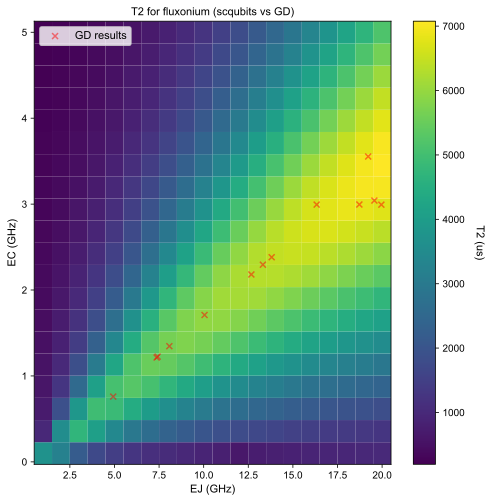

In [7]:
#2D COLOUR PLOT FOR EL = 0.2

import numpy as np
import matplotlib.pyplot as plt

EC = np.linspace(0.1,5,20) #EC range
EJ = np.linspace(1,20,20) #EJ range
EL = np.linspace(0.2,5,5) #EL range

#plotting T2 against our GD results

fig = plt.figure(figsize=[8,8])
ax = fig.add_subplot()
cm = ax.pcolormesh(EJ, EC, T2[:,:,0],label='scqubits plot')

ax.scatter(np.array(T2_data[:,0]),np.array(T2_data[:,1]),marker='x',color='r',alpha=0.5,label='GD results')

ax.set_xlabel("EJ (GHz)")
ax.set_ylabel("EC (GHz)")
ax.set_title("T2 for fluxonium (scqubits vs GD)")
cbar = plt.colorbar(cm,orientation='vertical')
cbar.set_label('T2 (us)', rotation=270, labelpad=20)
plt.legend(loc='upper left')
fig.savefig('Results2.png', bbox_inches='tight')

